# Network and Geospatial Analyses
## Part 2: Network Analysis
`Author: Stijn Overmeen (stijn.overmeen@nelen-schuurmans.nl)`

Assumed knowledge:
  - Pizzacursus netwerk en GEO-analyses in Python - Intro
  - Pizzacursus netwerk en GEO-analyses in Python - Part 1: Geospatial Analysis

This tutorial consists of Case 2:
  - [Case 2 - Afstand-tot-Koelte: analysing the network](#case2)
   
#### Disclaimer: This course material is intended solely for internal use within Nelen & Schuurmans and is provided exclusively for educational purposes. All rights, including copyright, pertaining to this material are owned or licensed by Nelen & Schuurmans.  

<a id='case2'></a>
### Case 2 - Afstand-tot-Koelte: analysing the network

In `Part 1` we have preprocessed the network. Now it is time to answer the clients questions: we will do the shortest path analysis from every building to the nearest cool spot.

Follow these steps to set up the network:
1. Load the preprocessed data into a geodataframe.
2. Calculate the length of each line and add it to a column in the geodataframe.
3. Set up the networkx graph.
4. Check the network connectivity. Is it in one network, or are there multiple sub-networks?
5. You will find that there are mistake in the network data that lead to multiple sub-networks. Open the network in QGIS, remove the isolated subsystems, save the geopackage and re-load it into this notebook.
6. Re-do steps 1 till 4.
7. Do the shortest path analysis.
8. Answer this question: what is the furthest walking distance from a building to any cool spot?

You can make use of the classes and functions provided below.

Note that the algorithm used for finding the shortest path is the `multi_source_dijkstra`. [Here](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) you can find more information on this topic.

In [ ]:
from shapely import Point
import networkx as nx
import geopandas as gpd
from tqdm import tqdm
from pathlib import Path
from rtree import index 

In [ ]:
TOLERANCE = 0.01 # for finding existing node

In [ ]:
class GeoDataFrame_2_Network:
    
    def __init__(self, network_gdf, buildings_gdf, cool_spots_gdf, cool_spot_id_field, building_id_field):
        
        self.gdf = network_gdf
        self.buildings_gdf = buildings_gdf
        self.cool_spots_gdf = cool_spots_gdf
        self.building_id_field = building_id_field
        self.cool_spot_id_field = cool_spot_id_field
        
        self.G = nx.MultiDiGraph() # initialise our multi directional network graph
        
        self.spatial_index_nodes = self.get_spatial_index_nodes(self.gdf)
        self.gdf_to_graph()
        
        undirected_graph = self.G.to_undirected() # make sure the graph is undirected for our walking distance analysis later on
        self.graph = nx.convert_node_labels_to_integers(undirected_graph, label_attribute='point') # we relabel the node indentifiers to integers, save coords as attribute 'point'

    def gdf_to_graph(self):
        
        for line_idx, line in tqdm(self.gdf.iterrows(), 
                total=len(self.gdf),
                desc="Puttin' them lines from the gdf into the network graph, let's get this party rollin'..."):
            
            geometry = line['geometry']
            start_node = geometry.coords[0]
            end_node = geometry.coords[-1]
            attributes = line.drop(["geometry"])
    
            self._add_edge_to_graph(start_node, end_node, geometry, **attributes)

    def _add_edge_to_graph(self, start_node, end_node, geometry, **attributes):
        """add a edge to the graph, without creating duplicate nodes within tolerance"""
        
        existing_start_node = self._find_existing_node(start_node)
        existing_end_node = self._find_existing_node(end_node)
                
        self.G.add_edge(existing_start_node, existing_end_node, geometry=geometry, **attributes)
        
        function_value = attributes.get("function")
        
        if function_value in ["building_connector", "cool_spot_connector"]:
            if function_value == "building_connector":
                
                building_id = attributes.get("building_id")
                building = self.buildings_gdf[self.buildings_gdf[self.building_id_field] == building_id]
                geom = building.iloc[0]["geometry"].simplify(2)              
                
                building_point, road_point = (existing_start_node, existing_end_node) if geom.distance(Point(existing_start_node)) < geom.distance(Point(existing_end_node)) else (existing_end_node, existing_start_node)
        
                self.G.nodes[building_point]["function"] = "building"
                self.G.nodes[building_point]["building_id"] = building_id
                self.G.nodes[road_point]["function"] = "building_connector"
        
            if function_value == "cool_spot_connector":
                
                cool_spot_id = attributes.get("cool_spot_id")
                cool_spot = self.cool_spots_gdf[self.cool_spots_gdf[self.cool_spot_id_field] == cool_spot_id]
                geom = cool_spot.iloc[0]["geometry"].simplify(2)
                
                cool_spot_point, road_point = (existing_start_node, existing_end_node) if geom.distance(Point(existing_start_node)) < geom.distance(Point(existing_end_node)) else (existing_end_node, existing_start_node)

                self.G.nodes[cool_spot_point]["function"] = "cool_spot"
                self.G.nodes[cool_spot_point]["cool_spot_id"] = cool_spot_id
                self.G.nodes[road_point]["function"] = "cool_spot_connector"

    def _find_existing_node(self, node):
        """return existing node within tolerance effectively by using spatial index"""
        
        point = Point(node)
        nearest_nodes = list(self.spatial_index_nodes.nearest(point.bounds, 1))
    
        if nearest_nodes:
            closest_index = nearest_nodes[0]
            closest_node = self.unique_nodes[closest_index]
            closest_distance = point.distance(Point(closest_node))
    
            if closest_distance < TOLERANCE:
                return closest_node  # Return the closest existing node
    
        return node  # No existing node found, return the new node
    
    def get_spatial_index_nodes(self, gdf):
        """get the unique nodes from gdf and create a spatial index"""
        self.unique_nodes = set()

        for idx, row in gdf.iterrows():
            geometry = row['geometry']  # Get the LineString geometry from the row
            start_node = geometry.coords[0]  # Extract the start node coordinates
            end_node = geometry.coords[-1]   # Extract the end node coordinates
            self.unique_nodes.add(start_node)
            self.unique_nodes.add(end_node)

        self.unique_nodes = list(self.unique_nodes)
        spatial_index_nodes = index.Index()
        for idx, node in enumerate(self.unique_nodes):
            spatial_index_nodes.insert(idx, Point(node).bounds)
            
        return spatial_index_nodes

In [ ]:
def check_connectivity_network(G):
    if nx.is_connected(G):
        print("The graph is connected.")
    else:
        # If not connected, find the number of connected components
        connected_components = list(nx.connected_components(G))
        num_components = len(connected_components)
        print(f"The graph is not connected. Number of connected components: {num_components}")

In [ ]:
#1 Load data
path = Path.cwd() / "output" / "smart_network_preprocessed.gpkg"
network = gpd.read_file(path, layer="smart_network preprocessed")
buildings = gpd.read_file(path, layer="buildings preprocessed")
cool_spots = gpd.read_file(path, layer="cool spots preprocessed")

In [ ]:
#2 Calculate length
network['length'] = network['geometry'].length.round(2)

In [ ]:
#3 Set-up networkx graph
geodataframe2network = GeoDataFrame_2_Network(
    network_gdf = network,
    buildings_gdf = buildings,
    cool_spots_gdf = cool_spots,
    building_id_field = "gid",
    cool_spot_id_field = "ident"
)

graph = geodataframe2network.graph

In [ ]:
#4 Check the network connectivity
check_connectivity_network(graph)

In [ ]:
#5 #6 ...

In [ ]:
#7 Shortest path analysis
buildings = [node for node in graph.nodes if "building_id" in graph.nodes[node]]
cool_spots = [node for node in graph.nodes if "cool_spot_id" in graph.nodes[node]]

shortest_distances = []

for building in tqdm(buildings, total=len(buildings), desc="Analysing shortest path for buildings"):
    try:
        distance, p = nx.multi_source_dijkstra(graph, sources=cool_spots, target=building, weight='length')
    except nx.NetworkXNoPath:
        raise
       
    shortest_distances.append({
        "path" : p,
        "distance" : distance,
        "building_id" : graph.nodes[building]['building_id']
    })

In [ ]:
# Answer the question
max_distance_element = max(shortest_distances, key=lambda x: x['distance'])
max_building_id = max_distance_element['building_id']
max_building_distance = max_distance_element['distance']

print(f"Building {max_building_id} has the largest walking distance: {max_building_distance} m.")

Of course, this is a very "thin" answer to the clients question.

Our Afstand-tot-Koelte tool is a bit more advanced and provides the actual path in GIS format when clicked on a building.

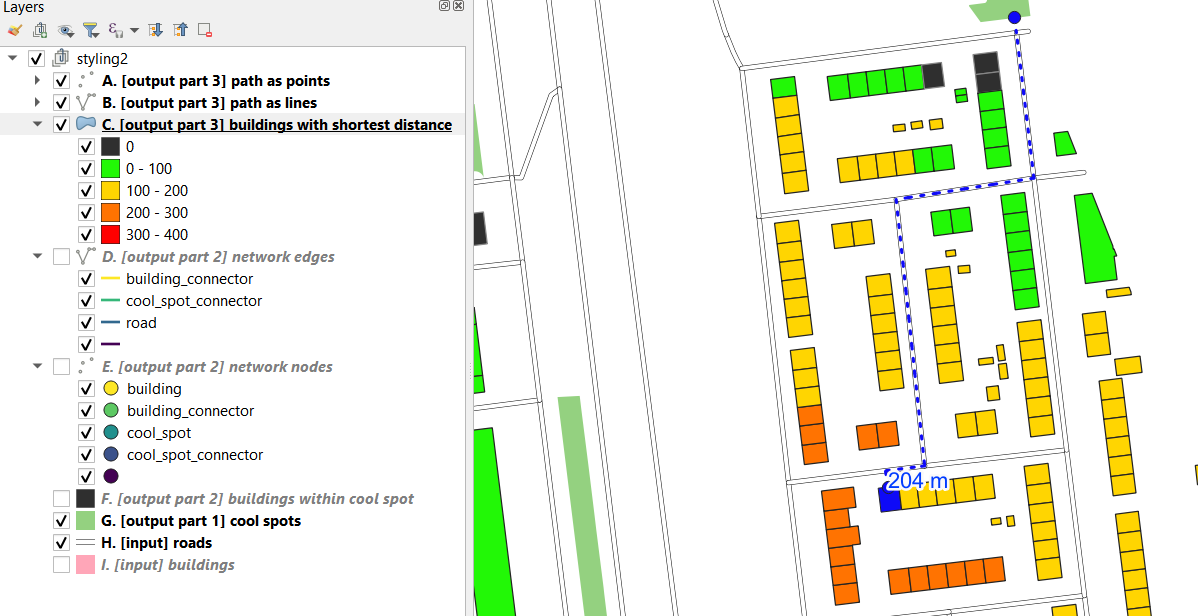